In [ ]:
!nvidia-smi

Tue Dec  2 15:41:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

###excess HuggingFace Token

In [ ]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

In [ ]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True


###Install SAM 3 and extra dependencies

In [ ]:
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e ".[notebooks]"
%cd /content

fatal: destination path 'sam3' already exists and is not an empty directory.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sam3 (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-0.editable-py3-none-any.whl size=15197 sha256=5bf79213facaf3a58795f28d61f553e2ab5e52d1d5ec27ec3d336638fdef5f43
  Stored in directory: /tmp/pip-ephem-wheel-cache-j1gj1leg/wheels/7c/90/be/80339bb9db8655024d6c9501da4e5efc6abbda4c897f5a6c43
Successfully built sam3
  Attempting uninstall: sam3
    Found existing installation: sam3 0.1.0
    Uninstalling sam3-0.1.0:
      Successfully uninstalled sam3-0.1.0
/content


In [ ]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 16.3 MB/s eta 0:00:00


In [ ]:
from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor

In [ ]:
model = build_sam3_image_model()
processor = Sam3Processor(model, confidence_threshold=0.6)

config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

sam3.pt:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

###Few utils to parse and visualize the result

In [ ]:
import supervision as sv

def from_sam(sam_result: dict) -> sv.Detections:
    xyxy = sam_result["boxes"].to(torch.float32).cpu().numpy()
    confidence = sam_result["scores"].to(torch.float32).cpu().numpy()

    mask = sam_result["masks"].to(torch.bool)
    mask = mask.reshape(mask.shape[0], mask.shape[2], mask.shape[3]).cpu().numpy()

    return sv.Detections(
        xyxy=xyxy,
        confidence=confidence,
        mask=mask
    )

In [ ]:
import supervision as sv
from PIL import Image
from typing import Optional


COLOR = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])


def annotate(image: Image.Image, detections: sv.Detections, label: Optional[str] = None) -> Image.Image:
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    mask_annotator = sv.MaskAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        opacity=0.6
    )
    box_annotator = sv.BoxAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        thickness=1
    )
    label_annotator = sv.LabelAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        text_scale=0.4,
        text_padding=5,
        text_color=sv.Color.BLACK,
        text_thickness=1
    )

    annotated_image = image.copy()
    annotated_image = mask_annotator.annotate(annotated_image, detections)
    annotated_image = box_annotator.annotate(annotated_image, detections)

    if label:
        labels = [
            f"{label} {confidence:.2f}"
            for confidence in detections.confidence
        ]
        annotated_image = label_annotator.annotate(annotated_image, detections, labels)

    return annotated_image

There are 1 doctor objects detected in the image.



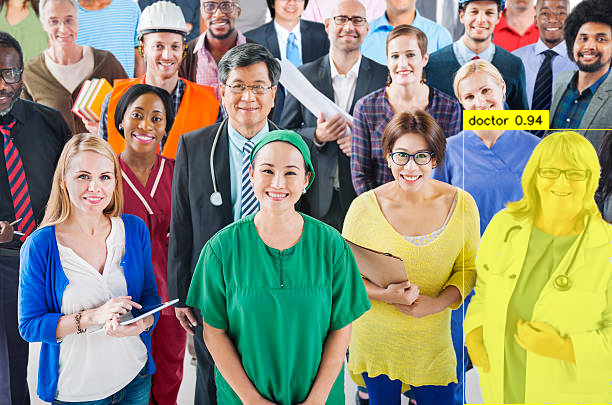

In [ ]:
from PIL import Image
from IPython.display import display

PROMPT = "doctor"
IMAGE_PATH = '/content/photo.jpg'

image = Image.open(IMAGE_PATH).convert("RGB")
inference_state = processor.set_image(image)
inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT)

detections = from_sam(sam_result=inference_state)
detections = detections[detections.confidence > 0.5]

print(f"There are {len(detections)} {PROMPT} objects detected in the image.\n")
annotate(image, detections, label=PROMPT)

There are 45 bird objects detected in the image.



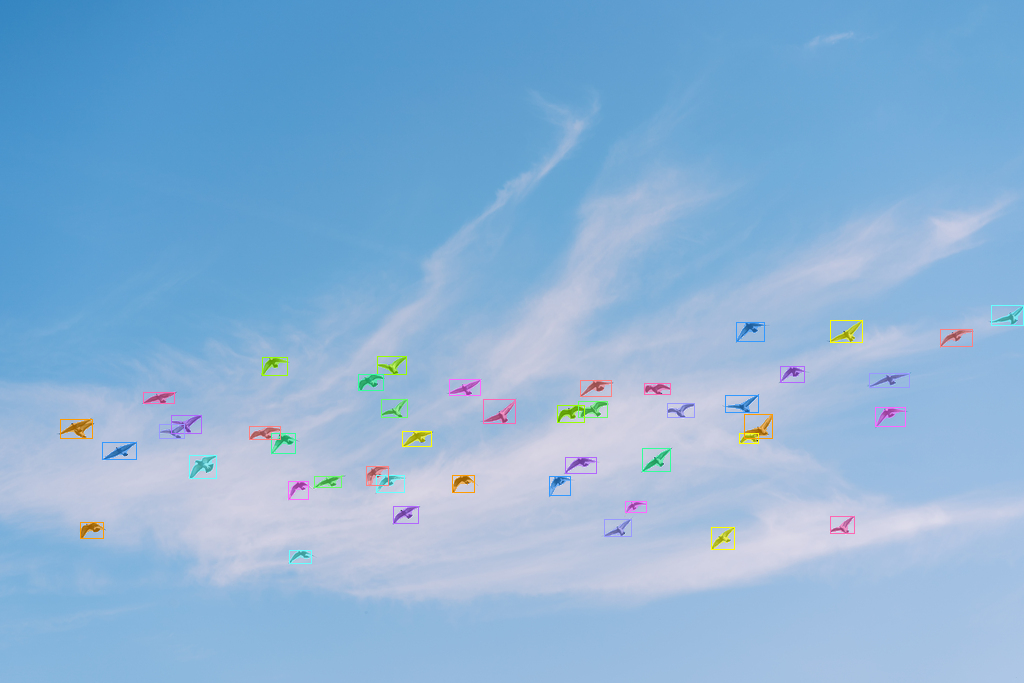

In [ ]:
from PIL import Image
from IPython.display import display

PROMPT = "bird"
IMAGE_PATH = '/content/birds.jpg'

image = Image.open(IMAGE_PATH).convert("RGB")
inference_state = processor.set_image(image)
inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT)

detections = from_sam(sam_result=inference_state)
detections = detections[detections.confidence > 0.5]

print(f"There are {len(detections)} {PROMPT} objects detected in the image.\n")
annotate(image, detections)

There are 32 man objects detected in the image.



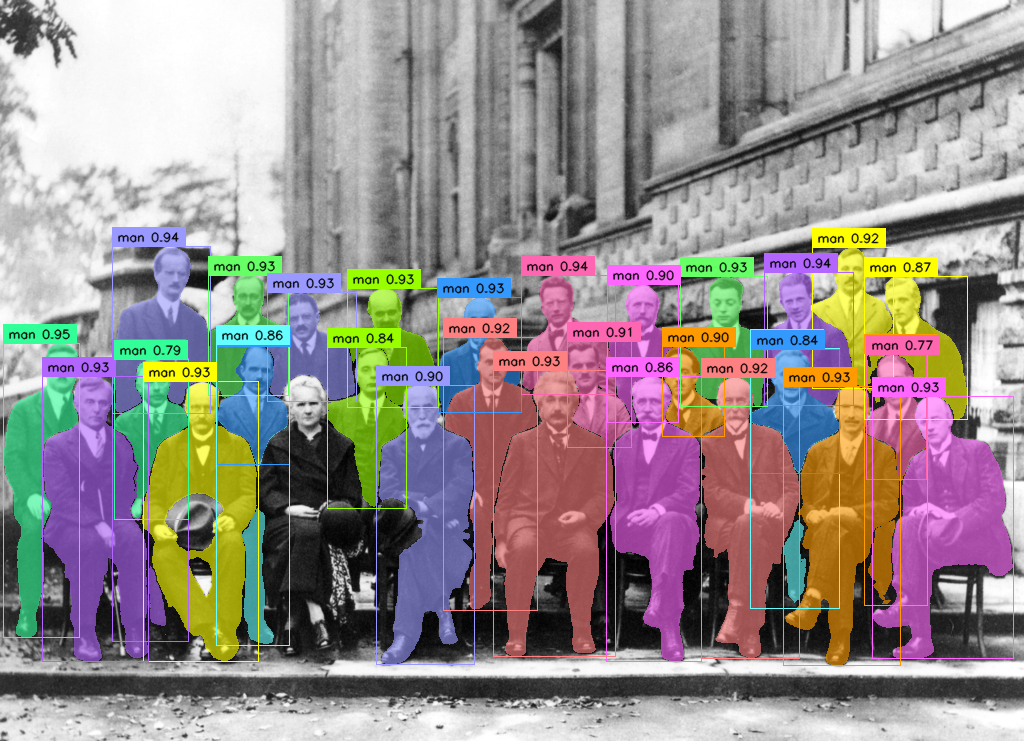

In [ ]:
from PIL import Image
from IPython.display import display

PROMPT = "man"
IMAGE_PATH = '/content/solvay_conference_1927.jpg'

image = Image.open(IMAGE_PATH).convert("RGB")
inference_state = processor.set_image(image)
inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT)

detections = from_sam(sam_result=inference_state)
detections = detections[detections.confidence > 0.5]

print(f"There are {len(detections)} {PROMPT} objects detected in the image.\n")
annotate(image, detections, label=PROMPT)

There are 1 man objects detected in the image.

There are 1 women objects detected in the image.



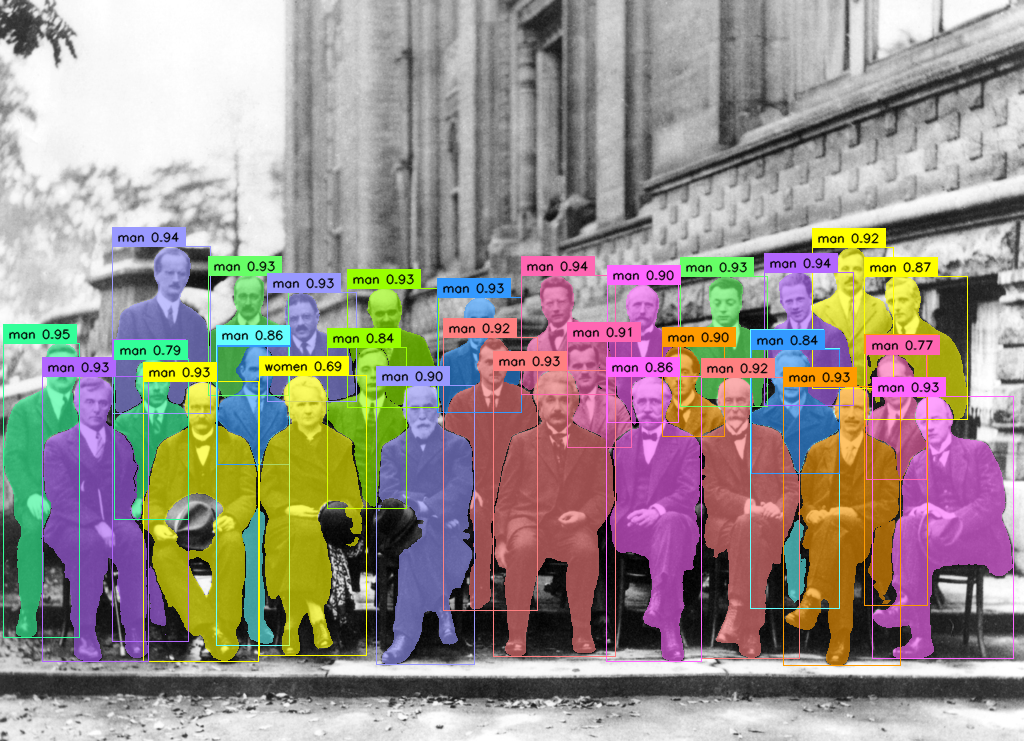

In [ ]:
from PIL import Image
from IPython.display import display

PROMPT_1 = "man"
PROMPT_2 = "women"
IMAGE_PATH = '/content/solvay_conference_1927.jpg'

image = Image.open(IMAGE_PATH).convert("RGB")
inference_state = processor.set_image(image)

inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT_1)
detections = from_sam(sam_result=inference_state)
detections_1 = detections[detections.confidence > 0.6]

inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT_2)
detections = from_sam(sam_result=inference_state)
detections_2 = detections[detections.confidence > 0.6]

print(f"There are {len(detections)} {PROMPT_1} objects detected in the image.\n")
print(f"There are {len(detections)} {PROMPT_2} objects detected in the image.\n")

image = annotate(image, detections_1, label=PROMPT_1)
image = annotate(image, detections_2, label=PROMPT_2)
image